# Homework 3 (100 points)

The goal of this homework is to practice techniques relating to GMM and SVD.

## Exercise 1 (25 points)

In this exercise we will implement 1-dimensional GMM clustering algorithm from scratch. A GMM distribution is composed of `k` components, each characterized by:

1. A mixture proportion
2. A mean for its Normal Distribution
3. A variance for its Normal Distribution

So, to generate a dataset that follows a GMM dsitrbution we need a list of those parameters. In this exercise we will use a class called `Component` to capture the parameters for a given component. And a GMM will be a list of `Component`s.

In [1]:
class Component:
    def __init__(self, mixture_prop, mean, variance):
        self.mixture_prop = mixture_prop
        self.mean = mean
        self.variance = variance

example_gmm = [Component(.5, 5, 1), Component(.5, 8, 1)]


a) Complete the function below to validate and generate a dataset following a GMM distribution, given a specified set of GMM parameters as above and a size. You may only use the methods already imported in the cell. (10pts)

In [2]:

from numpy.random import normal, uniform

def generate_gmm_dataset(gmm_params, size):
    if not is_valid_gmm(gmm_params):
        raise ValueError("GMM parameters are invalid")
    
    dataset = []
    for _ in range(size):
        comp = get_random_component(gmm_params)
        # mean_j, var_j of comp
        mean_j = comp.mean
        var_j = comp.variance
        dataset += [normal(mean_j, var_j)]
    return dataset

def is_valid_gmm(gmm_params):
    '''
        Checks that the sum of the mixture
        proportions is 1
    '''
    if abs(sum([comp.mixture_prop for comp in gmm_params]) -1) != 0:
        print("is_valid_gmm returns false")

    return True

def get_random_component(gmm_params):
    '''
        returns component with prob
        proportional to mixture_prop
    '''
    u = uniform()
    prob_sum = 0
    for comp in gmm_params:
        prob_sum += comp.mixture_prop
        if u <= prob_sum:
            return comp
    return gmm_params[-1]

# test your code: this should return a list of 10 numbers similar to worksheet 8
data = generate_gmm_dataset(example_gmm, 10)
print(data)

[7.9490908318149245, 5.522271509604284, 5.8156020180488355, 10.100229133797184, 5.646674466932788, 8.120996406941904, 7.531112991672513, 4.207668559673417, 8.920073382539059, 6.191570682802771]


b) Finish the implementation below of the Expectation-Maximization Algorithm. Only use methods that have been imported in the cell. (15pts)

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


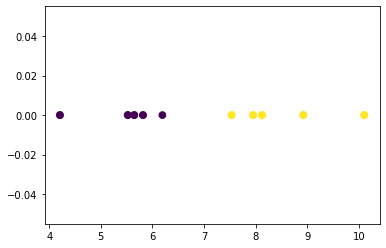

In [3]:

from scipy.stats import norm
from numpy import array, argmax
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def gmm_init(k, dataset):
    kmeans = KMeans(k, init='k-means++').fit(X=array(dataset).reshape(-1, 1))
    gmm_params = []
    for _ in range(k):
        mean_j = kmeans.cluster_centers_[_][0]
        var_j = kmeans.inertia_/(k* len(dataset))
        mixture_prop = 1/k
        gmm_params.append(Component(mixture_prop, mean_j, var_j))

    return gmm_params


def compute_gmm(k, dataset, probs):
    '''
        Compute P(C_j), mean_j, var_j
    '''
    gmm_params = []
    for j in range(k):
        probs_j = array([p[j] for p in probs])
        mixture_prop_j = probs_j.mean()
        mean_j = (probs_j * dataset).sum()/ probs_j.sum()
        var_j = (probs_j * (dataset - mean_j)**2).sum() / probs_j.sum()
        gmm_params.append(Component(mixture_prop_j, mean_j, var_j))
    return gmm_params


def compute_probs(k, dataset, gmm_params):
    '''
        For all x_i in dataset, compute P(C_j | X_i)
        = P(X_i | C_j)P(C_j) / P(X_i) for all C_j
        return the list of lists of all P(C_j | X_i)
        for all x_i in dataset.
    '''
    probs = []
    for x in dataset:
        px = sum([comp.mixture_prop* norm(comp.mean, comp.variance).pdf(x) for comp in gmm_params])

        p_x_given_c = [comp.mixture_prop* norm(comp.mean, comp.variance).pdf(x)/ px for comp in gmm_params]

        probs.append(p_x_given_c)
    
    return probs


def expectation_maximization(k, dataset, iterations):
    '''
        Repeat for a set number of iterations.
    '''
    gmm_params = gmm_init(k, dataset)
    for _ in range(iterations):
        # expectation step
        probs = compute_probs(k, dataset, gmm_params)

        # maximization step
        gmm_params = compute_gmm(k, dataset, probs)

    return probs, gmm_params


# for testing: you should see smaller sized points
# near the boundary of a cluster if it is close to another cluster
probs, gmm_p = expectation_maximization(2, data, 3)
labels = [argmax(array(p)) for p in probs] # create a hard assignment
size = 50 * array(probs).max(1) ** 2  # square to emphasize the difference
plt.scatter(data, [0.0 for _ in range(len(data))], c=labels, cmap='viridis', s=size)
plt.show()

Notes:

1. your code should work with any number of components, each with reasonable parameters.
2. your code should work for 1 to about 5 iterations of the EM algorithm. It may not work for iterations over 10 because the math we are doing may overflow and create `nans` - that's ok / don't worry about it.
3. worksheet 7 is your friend

## Exercise 2 (50 points)

a) Fetch the "mnist_784" data and store is as a `.csv` (that way you don't have to fetch it every time - which takes about 30s). (2.5 points)

In [1]:

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

X, y = fetch_openml(name="mnist_784", version=1, return_X_y=True, as_frame=False)

# your code here
import pandas as pd

df = pd.DataFrame(X, y)
# df.to_csv('mnist_784.csv', index=False)

/opt/homebrew/lib/python3.9/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


b) Plot the singular value plot for a single example of the 0 digit (2.5 points)

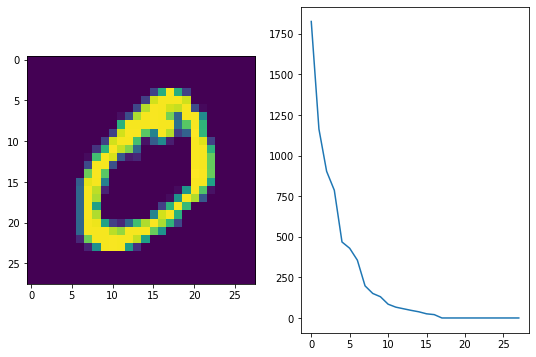

In [2]:
import numpy as np

singular_value = [] 

for i in range(len(X)):
    if y[i] == '0':
        singular_value = X[i]
        break

image = singular_value.reshape(28, 28) 

u, s, vh = np.linalg.svd(image)
fig, ax = plt.subplots(1, 2,figsize=(9, 6))




ax[0].imshow(image) 
ax[1].plot(s) 

c) Just like we did in class with the image of the boat: By setting some singular values to 0, plot the approximation of an image of a 0 digit next to the original image. (10 points)

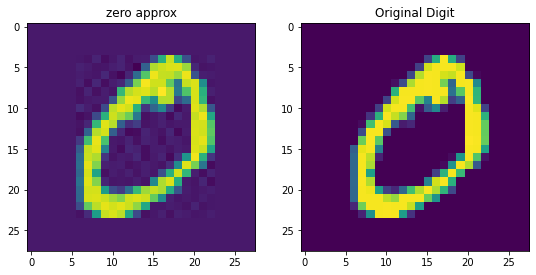

In [3]:
scopy =s.copy()
scopy[10:]=0.0

zero_image = u.dot(np.diag(scopy)).dot(vh)

plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
plt.imshow(zero_image)
plt.title('zero approx')

plt.subplot(1,2,2)
plt.imshow(image)
plt.title('Original Digit')
plt.show()

d) Consider the entire dataset as a matrix. Perform SVD and explain why / how you chose a particular rank. Note: you may not be able to run this on the entire dataset in a reasonable amount of time so you may take a small random sample for this and the following questions. (5 points)

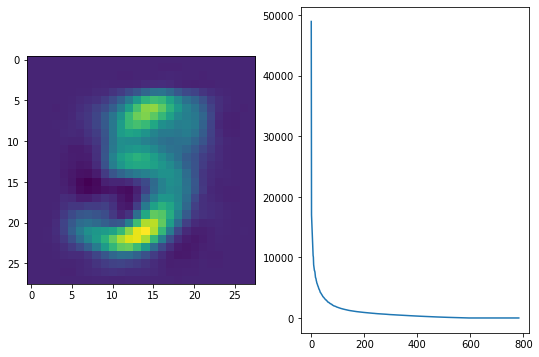

In [6]:
# print(X.shape)
# print(X[:1000].reshape(-1, 28,28).shape)

# print(X.shape)
# X = X.reshape(-1, 28,28)
# # print(X.shape)
# u1, s1, vh1 = np.linalg.svd(X[:1000], full_matrices = False)

# print(X[:1000].shape)
# # print(u1.shape)
# # print(s1.shape)
# # print(vh1.shape)

# rank = 10
# scopy1 =s1.copy()
# scopy1[rank:]=0




# dataset_approx = u1.dot(np.diag(scopy1)).dot(vh1)
# fig, ax = plt.subplots(1, 2,figsize=(9, 6))
# # ax[0].imshow(dataset_approx[0]) 
# ax[1].plot(s1) 

#***************************************************************

# zero_image1 = u1.dot(np.diag(scopy1)).dot(vt1).reshape(-1, 28,28)
# print(zero_image1.shape)

# ax1[0].imshow(zero_image1.reshape(28, 28)) 
# ax1[1].plot(s1) 

# plt.figure(figsize=(9,6))
# plt.subplot(1,2,1)
# plt.imshow(dataset_approx[0].reshape(28, 28))
# plt.title('dataset approx')

# plt.subplot(1,2,2)
# plt.imshow(image)
# plt.title('Original Digit')
# plt.show()

u1, s1, v1 = np.linalg.svd(X[:1000], full_matrices=False)

rank = 10

s1copy = s1.copy()
s1copy[rank:]=0.0
datasetApprox = u1.dot(np.diag(s1copy)).dot(v1).reshape(-1,28,28)
fig, ax = plt.subplots(1, 2,figsize=(9, 6))
ax[0].imshow(datasetApprox[0].reshape(28,28)) 
ax[1].plot(s1)



From the plot, we can see that the singular values decay rapidly, indicating that we can retain most of the information by choosing a relatively low rank. 10 is a good choice since the elbow is about 10 in the plot

e) As in homework 2, using Kmeans on this new dataset, cluster the images from d) using 10 clusters and plot the centroid of each cluster. Note: the centroids should be represented as images. (10 points)

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


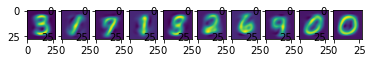

In [8]:
from sklearn.cluster import KMeans
#had to redo the new dataset, the dimension of the dataset in 1d does not fit here. 
zero_image2 = u1.dot(np.diag(scopy1)).dot(vt1)

kmeans_new_ds= KMeans(n_clusters=10)
clusters_new_ds = kmeans_new_ds.fit_predict(zero_image2)
centroids_new_ds  = kmeans_new_ds.cluster_centers_ 


centroids_new_copy = centroids_new_ds.reshape(10, 28, 28)

fig, ax = plt.subplots(1,10)
for i in range(10):
    ax[i].imshow(centroids_new_copy[i])

f) Repeat e) on the original dataset (if you used a subset of the dataset, keep using that same subset). Comment on any differences (or lack thereof) you observe between the centroids. (5 points)

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


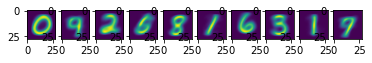

In [9]:
kmeans_old_ds= KMeans(n_clusters=10)
clusters_old_ds = kmeans_old_ds.fit_predict(X)
centroids_old_ds  = kmeans_old_ds.cluster_centers_ 


centroids_copy = centroids_old_ds.reshape(10, 28, 28)

fig, ax = plt.subplots(1,10)
for i in range(10):
    ax[i].imshow(centroids_copy[i])

both datasets are not doing good job custering data points of number 4 and 5 since we can see both 4 and 5 are missing from two graphs. In addition, the numbers shown in 1e are slightly more blured than the ones in 1f since 1e has the approximation of the dataset. 

g) Create a matrix (let's call it `O`) that is the difference between the original dataset and the rank-10 approximation of the dataset. (5 points)

In [10]:
O = X - zero_image2
# O.shape[0]
O

array([[-2.62272593e-15,  2.62658120e-13,  1.42987384e-13, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.46363890e-15,  2.55722599e-13,  1.12576991e-13, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.88487181e-16,  7.63116607e-14,  2.63821469e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 6.60028706e-16,  2.61438610e-13, -2.00285921e-13, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.59076933e-16,  1.68930263e-13,  4.21554287e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.02674393e-16,  3.49401441e-13, -2.76044478e-13, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

h) The largest (using euclidean distance from the origin) rows of the matrix `O` could be considered anomalous data points. Briefly explain why. Plot the 10 images responsible for the 10 largest rows of that matrix `O`. (10 points)

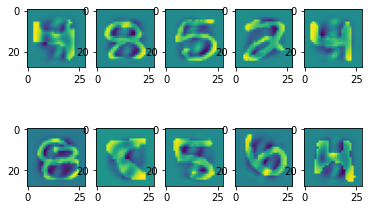

In [12]:
origins = [0 for i in range(O.shape[1])] #Origion for each cluster is 0
eucli_dist = [(np.linalg.norm(O[_]- origins)) for _ in range (O.shape[0])]
# eucli_dist
eucli_dist_array = np.array(eucli_dist)

# eucli_dist_array
sorted_array = np.argsort(eucli_dist_array)
top_ten = sorted_array[-10: ]
# top_ten
fig, ax = plt.subplots(2,5)
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(O[top_ten[i]].reshape(28, 28))

the largest 10 rows of the matrix are really anomalous since the 10 numbers shown above are really wonky. They are the outliers that make our results less accurate. 

## Exercise 3 (25pts)

For this question we will re-use the "mnist_784" dataset.

a) Begin by creating a training and testing datasest from our dataset, with a 80-20 ratio, and random_state=1. You can use the `train_test_split` function from sklearn. By holding out a portion of the dataset we can evaluate how our model generalizes to unseen data (i.e. data it did not learn from). **- 2 Points**

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# X_train
# X_test
y_train
# y_test

array(['9', '7', '1', ..., '5', '0', '0'], dtype=object)

b) For K ranging from 1 to 20:

1. train a KNN on the training data - **2 points**
2. record the training and testing accuracy - **2 points**

Plot a graph of the training and testing set accuracy as a function of the number of neighbors K (on the same plot). Which value of K is optimal? Briefly explain.  **- 4 points**

K is 1 , accuracy for training data is 1.0 , accuracy for testing data is 0.9723571428571428
K is 2 , accuracy for training data is 0.9854642857142857 , accuracy for testing data is 0.9675714285714285
K is 3 , accuracy for training data is 0.9863035714285714 , accuracy for testing data is 0.9722142857142857
K is 4 , accuracy for training data is 0.9825 , accuracy for testing data is 0.9709285714285715
K is 5 , accuracy for training data is 0.981 , accuracy for testing data is 0.9720714285714286
K is 6 , accuracy for training data is 0.978625 , accuracy for testing data is 0.9710714285714286
K is 7 , accuracy for training data is 0.9777678571428572 , accuracy for testing data is 0.9710714285714286
K is 8 , accuracy for training data is 0.9759821428571429 , accuracy for testing data is 0.9695714285714285
K is 9 , accuracy for training data is 0.9752321428571429 , accuracy for testing data is 0.9687142857142857
K is 10 , accuracy for training data is 0.9739821428571429 , accuracy for test

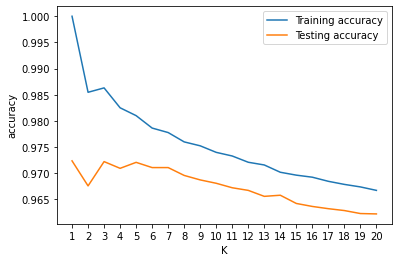

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
indices_for_x = []
train_acc = []
test_acc = []
optimal = 0
knn_optimal = None
optimal_K =1

for i in range(1, 21):
    indices_for_x.append(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    
    perdict_y_train = knn.predict(X_train)
    accuracy1 = accuracy_score(y_train, perdict_y_train)
    train_acc.append(accuracy1)
    
    perdict_y_test = knn.predict(X_test)
    accuracy2 = accuracy_score(y_test, perdict_y_test)
    test_acc.append(accuracy2)
    
    #test
    
    print("K is", i, ", accuracy for training data is", accuracy1, ", accuracy for testing data is", accuracy2)
    
    if accuracy2> optimal:
        optimal = accuracy2
        optimal_K = i
        knn_optimal = knn
        
print("optimal K is", optimal_K)
plt.xlabel("K")
plt.ylabel("accuracy")
plt.xticks(np.arange(1,21,1))
plt.plot(indices_for_x, train_acc, label = 'Training accuracy')
plt.plot(indices_for_x, test_acc, label = 'Testing accuracy')
plt.legend()
plt.show()
    


K=1 gives the optimal model since it gives the best accuracy. 

c) Using the best model from b), pick an image at random and plot it next to its K nearest neighbors (5pts)

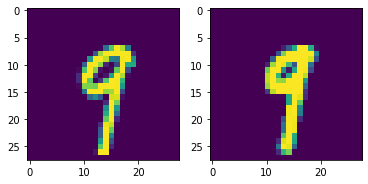

In [41]:
import random

random_image = random.randrange(len(X_test)) 


neighbor = knn_optimal.kneighbors([X_test[random_image]],return_distance=False)


plt.subplot(1,2,1)
plt.imshow([X_test[random_image]][0].reshape(28, 28)) 


i = 2
for n in neighbor[0]:
    plt.subplot(1,2,i)
    plt.imshow(X_train[n].reshape(28, 28))
    
    i += 1
    
plt.show()


In [ ]:
# random_image_index = random.randint(0,10)
# random_image_index

0

d) Using a dimensionality reduction technique discussed in class, reduce the dimensionality of the dataset before applying a KNN model. Repeat b) and discuss similarities and differences to the previous model. Briefly discuss your choice of dimension and why you think the performance / accuracy of the model has changed. (10 points)

K is 1 , accuracy for training data is 1.0 , accuracy for testing data is 0.9166428571428571
K is 2 , accuracy for training data is 0.9605535714285715 , accuracy for testing data is 0.9152857142857143
K is 3 , accuracy for training data is 0.9616428571428571 , accuracy for testing data is 0.9260714285714285
K is 4 , accuracy for training data is 0.9556428571428571 , accuracy for testing data is 0.9296428571428571
K is 5 , accuracy for training data is 0.9526428571428571 , accuracy for testing data is 0.9297142857142857
K is 6 , accuracy for training data is 0.9505 , accuracy for testing data is 0.9300714285714285
K is 7 , accuracy for training data is 0.9478214285714286 , accuracy for testing data is 0.9287857142857143
K is 8 , accuracy for training data is 0.9470892857142857 , accuracy for testing data is 0.9302142857142857
K is 9 , accuracy for training data is 0.9441964285714286 , accuracy for testing data is 0.9296428571428571
K is 10 , accuracy for training data is 0.9439107142857

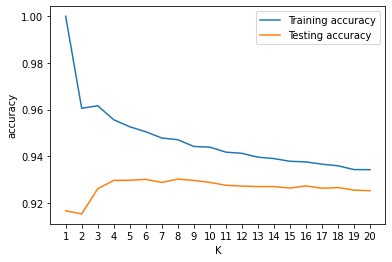

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA



#origional b
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
indices_for_x = []
train_acc = []
test_acc = []
optimal = 0
knn_optimal = None

for i in range(1, 21):
    indices_for_x.append(i)
    dimensionality_reduction = PCA(n_components = 10) #add pca as dimension reduction technique here
    knn = KNeighborsClassifier(n_neighbors=i)
    model = make_pipeline(dimensionality_reduction, knn)

    model.fit(X_train, y_train)
    
    perdict_y_train = model.predict(X_train)
    accuracy1 = accuracy_score(y_train, perdict_y_train)
    train_acc.append(accuracy1)
    
    perdict_y_test = model.predict(X_test)
    accuracy2 = accuracy_score(y_test, perdict_y_test)
    test_acc.append(accuracy2)
    
    #test
    
    print("K is", i, ", accuracy for training data is", accuracy1, ", accuracy for testing data is", accuracy2)
    
    if accuracy2> optimal:
        optimal = accuracy2
        optimal_K = i
        knn_optimal = model
        
print("optimal K is", optimal_K)
plt.xlabel("K")
plt.ylabel("accuracy")
plt.xticks(np.arange(1,21,1))
plt.plot(indices_for_x, train_acc, label = 'Training accuracy')
plt.plot(indices_for_x, test_acc, label = 'Testing accuracy')
plt.legend()
plt.show()

From the two graphs, we can say the two methods give really similar trend. KNN method tells us when K=1, the accuracy is the highest. PCA method tells us when K=8, the accuracy is the highest. Two graphs show the accuracies drop significantly at K=2 and goes back up at 3. For the second method, we have the highest accuracies slightly lower than the ones in 3b. For dimensionality reduction, I chose to use PCA as the method. It is rather a fast process and isn't computationally that expensive than running KNN on the whole dataset since i've reduced the dimension to 10

## Bonus (20 points)

Complete the code below to support N-dimensional GMM clustering. Only use the methods imported below. Please take a look at the comments and docstrings for more info.

In [9]:
from numpy import array, argmax
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from numpy.random import multivariate_normal, uniform

class Component:
    def __init__(self, mixture_prop, mean, variance):
        self.mixture_prop = mixture_prop
        self.mean = mean
        self.variance = variance

nd_gmm = [
    Component(.25, [-1, 1], [[1, 0], [0, 1]]),
    Component(.50, [0, 0], [[1, 0], [0, 1]]),
    Component(.25, [1, 1], [[1, 0], [0, 1]])
]
def get_random_component(gmm_params):
    '''
        returns component with prob
        proportional to mixture_prop
    '''
    u = uniform()
    prob_sum = 0
    for comp in gmm_params:
        prob_sum += comp.mixture_prop
        if u <= prob_sum:
            return comp
    return gmm_params[-1]

def generate_nd_gmm_dataset(gmm_params, size):
    if not is_valid_nd_gmm(gmm_params):
        raise ValueError("GMM parameters are invalid")
    
    dataset = []
    for _ in range(size):
        comp = get_random_component(gmm_params)
        mean_j = comp.mean
        var_j = comp.variance
        dataset += [normal(mean_j, var_j)]
        
    return array(dataset) # this should be a numpy array instead of a list


def is_valid_nd_gmm(gmm_params):
    '''
        Check that all the dimensions are consistent
        accross all components
    '''
    dimension = len(gmm_params[0].mean)
    mean_j = comp.mean
    var_j = comp.variance
    for comp in gmm_params:
        if len(mean_j) != dimension or var_j.shape != (dimension, dimension):
            return False

    return is_valid_gmm(gmm_params) # checks if mixture components add to 1
def is_valid_gmm(gmm_params):
    '''
        Checks that the sum of the mixture
        proportions is 1
    '''
    if abs(sum([comp.mixture_prop for comp in gmm_params]) -1) != 0:
        print("is_valid_gmm returns false")

    return True

def gmm_nd_init(k, dataset):

    kmeans = KMeans(k, init='k-means++').fit(X=array(dataset).reshape(-1, 1))
    gmm_params = []
    for _ in range(k):
        mean_j = kmeans.cluster_centers_[_][0]
        var_j = kmeans.inertia_/(k* len(dataset))
        mixture_prop = 1/k
        gmm_params.append(Component(mixture_prop, mean_j, var_j))



    return gmm_params


def compute_nd_gmm(k, dataset, probs):
    '''
        Compute P(C_j), mean_j, var_j

        Here mean_j is a vector and var_j is a matrix
    '''
    gmm_params = []
    n_dim = dataset.shape[1]

    for i in range(k):
        weight = sum(probs[:, i]) / len(dataset)
        mean = np.zeros(n_dim)
        for j in range(len(dataset)):
            mean += probs[j, i] * dataset[j]
        mean /= sum(probs[:, i])
        covariance = np.zeros((n_dim, n_dim))
        for j in range(len(dataset)):
            diff = dataset[j] - mean
            covariance += probs[j, i] * (diff.reshape(-1, 1) @ diff.reshape(1, -1))
        covariance /= sum(probs[:, i])
        gmm_params.append(Component(weight, mean, covariance))
    return gmm_params



def compute_nd_probs(k, dataset, gmm_params):
    '''
        For all x_i in dataset, compute P(C_j | X_i)
        = P(X_i | C_j)P(C_j) / P(X_i) for all C_j
        return the list of lists of all P(C_j | X_i)
        for all x_i in dataset.
        
        Here x_i are vectors
    '''
    probs = []
    for x in dataset:
        px = 0
        for comp in gmm_params:
            px += comp.mixture_prop * multivariate_normal.pdf(x, comp.mean, comp.variance)
        row = [comp.mixture_prop * multivariate_normal.pdf(x, comp.mean, comp.variance) / px for comp in gmm_params]
       
    return probs


def expectation_maximization_nd(k, dataset, iterations):
    '''
        Repeat for a set number of iterations.
    '''
    gmm_params = gmm_nd_init(k, dataset)
    for _ in range(iterations):
        # expectation step
        probs = compute_nd_probs(k, dataset, gmm_params)

        # maximization step
        gmm_params = compute_nd_gmm(k, dataset, probs)

    return probs, gmm_params


data = generate_nd_gmm_dataset(nd_gmm, 100)
probs, gmm_p = expectation_maximization_nd(2, data, 3)
labels = [argmax(array(p)) for p in probs] # create a hard assignment
size = 50 * array(probs).max(1) ** 2
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=size)
plt.show()

UnboundLocalError: local variable 'comp' referenced before assignment